# DSC540 Final Project

#### Aaron Gregory

The goal of this project is to create a model using NFL box score data from 2017-2021 to predict how much a team scores in a given game. This can then be leveraged for betting purposes or to see what areas of a game impact scoring the most. I scraped the box score data from https://www.pro-football-reference.com/ and saved it into a CSV previously. The data includes lots of raw counting statistics like total yards opponent's turnovers 1st downs etc. The data set also includes some more advanced metrics like offensive, deffensive and special teams efficency which do a better job looking at the play to play success of a team.

Trying to model scores of these games is inherently dificult do to the randomness of a game that is not always able to be captured in a box score. If a team has a great drive but has a turnover right before the endzone the box score will probably look good even though the team didn't score. For that purpose I tried to lessen the impact of the outliers as it is more important to have our model be good for the large chunk of the bell curve and not the extreams.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [53]:
df = pd.read_csv('NFL_boxscores_2018_2022.csv',sep="\t")
df = df.drop("Unnamed: 0",axis=1)
df.head()

,Offense,Defense,Tm,OppScore,Sp. Tms,TO,1stD,TotYd,PassY,RushY,Opp1stD,OppTotYd,OppPassY,OppRushY,OppTO,Opp,Team
0,-7.26,3.11,12.0,18.0,2.58,1.0,16.0,299.0,225.0,74.0,18.0,232.0,119.0,113.0,2.0,Philadelphia Eagles,atl
1,22.04,-12.68,31.0,24.0,-4.66,1.0,23.0,442.0,272.0,170.0,27.0,439.0,318.0,121.0,1.0,Carolina Panthers,atl
2,20.31,-26.85,37.0,43.0,0.47,0.0,24.0,407.0,359.0,48.0,32.0,534.0,391.0,143.0,0.0,New Orleans Saints,atl
3,24.63,-22.54,36.0,37.0,1.75,0.0,25.0,495.0,403.0,92.0,30.0,407.0,308.0,99.0,1.0,Cincinnati Bengals,atl
4,-1.13,-20.96,17.0,41.0,-0.44,1.0,22.0,324.0,262.0,62.0,22.0,381.0,250.0,131.0,1.0,Pittsburgh Steelers,atl


In [54]:
#There are no missing data
df.isnull().sum()

Offense     0
Defense     0
Tm          0
OppScore    0
Sp. Tms     0
TO          0
1stD        0
TotYd       0
PassY       0
RushY       0
Opp1stD     0
OppTotYd    0
OppPassY    0
OppRushY    0
OppTO       0
Opp         0
Team        0
dtype: int64

AxesSubplot(0.125,0.125;0.62x0.755)


,Offense,Defense,Tm,OppScore,Sp. Tms,TO,1stD,TotYd,PassY,RushY,Opp1stD,OppTotYd,OppPassY,OppRushY,OppTO
Offense,1.000000,-0.115324,0.800096,-0.097135,-0.294530,-0.458921,0.690294,0.737889,0.530928,0.393341,0.095060,0.069500,0.187832,-0.171287,0.040467
Defense,-0.115324,1.000000,0.097135,-0.800096,-0.294530,-0.040467,-0.095060,-0.069500,-0.187832,0.171287,-0.690294,-0.737889,-0.530928,-0.393341,0.458921
Tm,0.800096,0.097135,1.000000,-0.022330,-0.115333,-0.296311,0.589876,0.652176,0.447024,0.381256,0.060381,0.058888,0.198171,-0.204114,0.308455
OppScore,-0.097135,-0.800096,-0.022330,1.000000,0.115333,0.308455,0.060381,0.058888,0.198171,-0.204114,0.589876,0.652176,0.447024,0.381256,-0.296311
Sp. Tms,-0.294530,-0.294530,-0.115333,0.115333,1.000000,-0.001353,-0.320264,-0.360283,-0.284271,-0.154205,0.320264,0.360283,0.284271,0.154205,0.001353
TO,-0.458921,-0.040467,-0.296311,0.308455,-0.001353,1.000000,-0.052077,-0.050459,0.045651,-0.150783,-0.029859,-0.023680,-0.103685,0.118351,-0.108985
1stD,0.690294,-0.095060,0.589876,0.060381,-0.320264,-0.052077,1.000000,0.802428,0.623980,0.357282,-0.089673,-0.043247,0.065023,-0.168378,-0.029859
TotYd,0.737889,-0.069500,0.652176,0.058888,-0.360283,-0.050459,0.802428,1.000000,0.798332,0.413936,-0.043247,0.006310,0.119809,-0.170876,-0.023680
PassY,0.530928,-0.187832,0.447024,0.198171,-0.284271,0.045651,0.623980,0.798332,1.000000,-0.217744,0.065023,0.119809,0.153644,-0.038073,-0.103685
RushY,0.393341,0.171287,0.381256,-0.204114,-0.154205,-0.150783,0.357282,0.413936,-0.217744,1.000000,-0.168378,-0.170876,-0.038073,-0.219385,0.118351


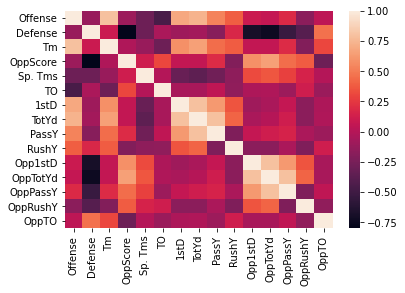

In [55]:
print(sns.heatmap(df.corr()))
df.corr()

Our heat map doesn't show anything too suprising. We would expect things like turnovers to be negatively correlated with offensive efficiency. Special teams being negativly correlated with offense and deffense is weird as I wouldn't think that there is a connection.

In [56]:
corr=df.corr().unstack().sort_values()[df.corr().unstack().sort_values()>0.75]
print("Correlations greater than 0.75 in the data set")
print(corr[corr!=1].drop_duplicates())

Correlations greater than 0.75 in the data set
PassY     TotYd       0.798332
OppTotYd  OppPassY    0.798332
Tm        Offense     0.800096
OppTotYd  Opp1stD     0.802428
TotYd     1stD        0.802428
dtype: float64


<AxesSubplot:xlabel='Tm', ylabel='Count'>

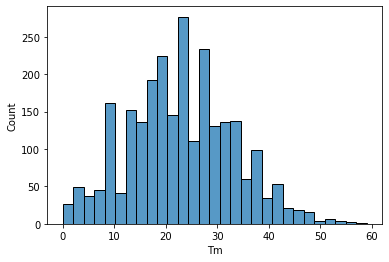

In [57]:
sns.histplot(df["Tm"])

Looking at this histogram we can see a long tail. It is not benefical for our model to correctly predict these points since vegas is almost never going to set a team total about 33 points. The logic is that if vegas says a team will score 33 points and our model predicts 35 then we would bet the over and win the bet even if they end up scoring 50 points.

[Text(0.5, 1.0, 'Points vs Offensive efficiency')]

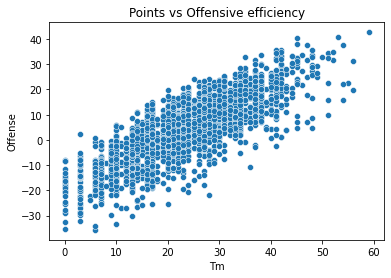

In [58]:
sns.scatterplot(df["Tm"],df["Offense"]).set(title = "Points vs Offensive efficiency")

[Text(0.5, 1.0, 'Points vs Deffensive efficiency')]

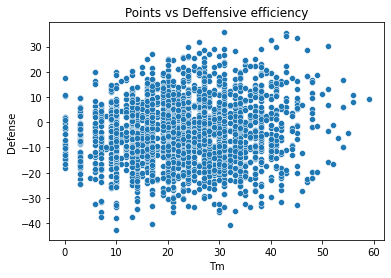

In [59]:
sns.scatterplot(df["Tm"],df["Defense"]).set(title = "Points vs Deffensive efficiency")

Defense really doesn't have that large of an impact on the points a team scores. 

In [226]:
print("Games where a team scores more than 38 points:", str(sum(y>38)))

Games where a team scores more than 38 points: 164


In [66]:
#modified target variable to reduce the influenece of out lier events
y = df.Tm
y_mod=y.copy()
for score in enumerate (y_mod):
    if score[1]>38:
        y_mod[score[0]]= 38
    if score[1]<7:
        y_mod[score[0]]=7
y_mod.head()

0    12.0
1    31.0
2    37.0
3    36.0
4    17.0
Name: Tm, dtype: float64

I created this second modified target dataset for two reasons. One we see a long tail in the distribution and don't want the outliers to have such an impact. Also if we are to use this for betting purposes no team will have a total above 38 points or below 7. If we project a team to score 7 points that is okay if they end up scoring less than 7 points. Also on the high end we would expect there to be some fluky plays like return touchdowns that we cannot effectivley model with our data.

## Dataset prep
- Create training test splits
- Normalize the data

In [193]:
from sklearn import preprocessing
RANDOM_STATE = 0    #Makes models recreatable

y = df.Tm
X = df.drop(['Tm', 'OppScore','Opp', 'Team'], axis=1)
#X=(X-X.mean())/X.std()      # Normalization of the data set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=RANDOM_STATE)

X_train, X_test, y_train_mod, y_test_mod = train_test_split(X, y_mod, test_size=0.10, random_state=RANDOM_STATE)
X_train, X_val, y_train_mod, y_val_mod = train_test_split(X_train, y_train_mod, test_size=0.20, random_state=RANDOM_STATE)

#standardization of dataset
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [32]:
#Helper Function
def scoreValues(trainPreds, valPreds, y_train, y_val):   
    trainR2   = round (metrics.r2_score(trainPreds,y_train),3)
    valR2     = round (metrics.r2_score(valPreds, y_val),3)

    rmseTrain = round (metrics.mean_squared_error(trainPreds,y_train)**0.5,3)
    rmseVal   = round (metrics.mean_squared_error(valPreds,y_val)**0.5, 3)
    
    print("Training Data R2 Value     : ", trainR2)
    print("Validation Data R2 Value   : ", valR2)
    print("")
    print("Training Data RMSE Value   : ", rmseTrain)
    print("Validation Data RMSE Value : ", rmseVal)

In [33]:
reg_results=pd.DataFrame(columns=['R2','RMSE'])

def resultsAdd(tabel, testPreds, y_test, model):   
    testR2     = round (metrics.r2_score(testPreds,y_test),3)
    rmseTest   = round (metrics.mean_squared_error(testPreds,y_test)**0.5, 3)
    tabel.at[model,"R2"] = testR2
    tabel.at[model,"RMSE"]= rmseTest

## Linear Regression

In [156]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression()
linear.fit(X_train,y_train)
lin_train = linear.predict(X_train)
lin_val   = linear.predict(X_val)
lin_test   = linear.predict(X_test)

scoreValues(lin_train, lin_val, y_train, y_val)

Training Data R2 Value     :  0.732
Validation Data R2 Value   :  0.733

Training Data RMSE Value   :  4.594
Validation Data RMSE Value :  4.596


In [69]:
resultsAdd(reg_results, lin_test, y_test_mod, "Linear Regression")

In [166]:
# Modified target result
linear = LinearRegression()
linear.fit(X_train,y_train_mod)
lin_train = linear.predict(X_train)
lin_val   = linear.predict(X_val)
lin_test   = linear.predict(X_test)

scoreValues(lin_train, lin_val, y_train_mod, y_val_mod)

Training Data R2 Value     :  0.708
Validation Data R2 Value   :  0.712

Training Data RMSE Value   :  4.277
Validation Data RMSE Value :  4.265


In [167]:
resultsAdd(reg_results, lin_test, y_test_mod, "Linear Regression Modified")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=RANDOM_STATE

In [199]:
#I stole this from a blog so I could easily see the p-values. This caused me to drop 1st downs as a variable
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                     Tm   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     751.4
Date:                Mon, 23 Jan 2023   Prob (F-statistic):               0.00
Time:                        20:04:59   Log-Likelihood:                -5426.2
No. Observations:                1841   AIC:                         1.087e+04
Df Residuals:                    1831   BIC:                         1.093e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9744      1.051      3.780      0.0

## Random Forest Regression

In [74]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
rf.fit(X_train,y_train)
rf_train_preds = rf.predict(X_train)
rf_val_preds = rf.predict(X_val)
scoreValues(rf_train_preds,rf_val_preds,y_train,y_val)

Training Data R2 Value     :  0.958
Validation Data R2 Value   :  0.685

Training Data RMSE Value   :  1.883
Validation Data RMSE Value :  4.974


In [75]:
params = dict(max_depth= [6,7,8,9], min_samples_split = [10, 20, 30, 40, 60])
rf = GridSearchCV(estimator= rf, param_grid=params, n_jobs=-1)
rf.fit(X_train, y_train)
rf.best_params_

{'max_depth': 9, 'min_samples_split': 10}

Note that this doesn't work for random forrest since it will always overfit the model

In [47]:
rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE,max_depth = 7, min_samples_split= 60)
rf.fit(X_train,y_train)

rf_train_preds = rf.predict(X_train)
rf_val_preds = rf.predict(X_val)
rf_test_preds = rf.predict(X_test)

scoreValues(rf_train_preds,rf_val_preds,y_train,y_val)

Training Data R2 Value     :  0.714
Validation Data R2 Value   :  0.566

Training Data RMSE Value   :  4.614
Validation Data RMSE Value :  5.339


In [48]:
resultsAdd(reg_results, rf_test_preds, y_test_mod, "Random Forest")

## Random forrest with modified results set

In [49]:
rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
rf.fit(X_train,y_train_mod)
rf_train_preds = rf.predict(X_train)
rf_val_preds = rf.predict(X_val)
scoreValues(rf_train_preds,rf_val_preds,y_train_mod,y_val_mod)

Training Data R2 Value     :  0.958
Validation Data R2 Value   :  0.626

Training Data RMSE Value   :  1.72
Validation Data RMSE Value :  4.643


In [192]:
params = dict(max_depth= [6,7,8,9], min_samples_split = [10, 20, 30, 40, 60])
rf = GridSearchCV(estimator= rf, param_grid=params, n_jobs=-1)
rf.fit(X_train, y_train_mod)
rf.best_params_

{'max_depth': 9, 'min_samples_split': 10}

In [50]:
rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE,max_depth = 7, min_samples_split= 30)
rf.fit(X_train,y_train_mod)

rf_train_preds = rf.predict(X_train)
rf_val_preds = rf.predict(X_val)
rf_test_preds = rf.predict(X_test)

scoreValues(rf_train_preds,rf_val_preds,y_train_mod,y_val_mod)

Training Data R2 Value     :  0.756
Validation Data R2 Value   :  0.602

Training Data RMSE Value   :  3.844
Validation Data RMSE Value :  4.682


In [51]:
resultsAdd(reg_results, rf_test_preds, y_test_mod, "Random Forest Modified")

For random forrest we see some overfitting noted by the difference between testing and training R2 values and RMSE. This is why I did not chose the parameters shown by grid search. Instead I tried  to find a model with less overfitting

## SVM

In [52]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train,y_train)
svr_rbf_train_preds = svr_rbf.predict(X_train)
svr_rbf_val_preds = svr_rbf.predict(X_val)

scoreValues(svr_rbf_train_preds,svr_rbf_val_preds,y_train,y_val)

Training Data R2 Value     :  0.604
Validation Data R2 Value   :  0.522

Training Data RMSE Value   :  5.057
Validation Data RMSE Value :  5.395


In [53]:
svr_rbf = SVR()
params = dict(C= [100, 1000 ,2000 ,5000 ,1000],gamma = [0.0001, 0.001, 0.01], 
              kernel = ['linear', 'poly', 'rbf', 'sigmoid'])
rbf = GridSearchCV(estimator=svr_rbf, param_grid=params, n_jobs=-1)
rbf.fit(X_train, y_train)
rbf.best_params_

{'C': 5000, 'gamma': 0.001, 'kernel': 'rbf'}

In [54]:
svr_rbf = SVR(kernel='rbf', C= 5000, gamma= 0.001)
svr_rbf.fit(X_train,y_train)
svr_rbf_train_preds = svr_rbf.predict(X_train)
svr_rbf_val_preds = svr_rbf.predict(X_val)
svr_rbf_test_preds = svr_rbf.predict(X_test)

scoreValues(svr_rbf_train_preds,svr_rbf_val_preds,y_train,y_val)

Training Data R2 Value     :  0.75
Validation Data R2 Value   :  0.69

Training Data RMSE Value   :  4.587
Validation Data RMSE Value :  4.818


In [55]:
resultsAdd(reg_results, svr_rbf_test_preds, y_test_mod, "SVM")

## SVM Modified Results Set

In [56]:
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train,y_train_mod)
svr_rbf_train_preds = svr_rbf.predict(X_train)
svr_rbf_val_preds = svr_rbf.predict(X_val)

scoreValues(svr_rbf_train_preds,svr_rbf_val_preds,y_train_mod,y_val_mod)

Training Data R2 Value     :  0.682
Validation Data R2 Value   :  0.618

Training Data RMSE Value   :  4.36
Validation Data RMSE Value :  4.644


In [57]:
svr_rbf = SVR()
params = dict(C= [100, 1000 ,2000 ,5000 ,1000],gamma = [0.0001, 0.001, 0.01], 
              kernel = ['linear', 'poly', 'rbf', 'sigmoid'])
rbf = GridSearchCV(estimator=svr_rbf, param_grid=params, n_jobs=-1)
rbf.fit(X_train, y_train_mod)
rbf.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [58]:
svr_rbf = SVR(kernel='rbf', C= 100, gamma= 0.01)
svr_rbf.fit(X_train,y_train_mod)
svr_rbf_train_preds = svr_rbf.predict(X_train)
svr_rbf_val_preds = svr_rbf.predict(X_val)
svr_rbf_test_preds = svr_rbf.predict(X_test)

scoreValues(svr_rbf_train_preds,svr_rbf_val_preds,y_train_mod,y_val_mod)

Training Data R2 Value     :  0.75
Validation Data R2 Value   :  0.7

Training Data RMSE Value   :  4.178
Validation Data RMSE Value :  4.413


In [59]:
resultsAdd(reg_results, svr_rbf_test_preds, y_test_mod, "SVM Modified Results")

SVM with an rbf kernel on the modied data set has provided by far the best results out of any model with the validation RMSE of only 4.41. This is 5% improvement over the unmodified set with out sacraficing any of the upside of our model.

## KNN Regressor

In [60]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train,y_train)
neigh_train_preds = neigh.predict(X_train)
neigh_val_preds = neigh.predict(X_val)

scoreValues(neigh_train_preds,neigh_val_preds,y_train,y_val)

Training Data R2 Value     :  0.681
Validation Data R2 Value   :  0.442

Training Data RMSE Value   :  4.768
Validation Data RMSE Value :  5.948


In [61]:
neigh = KNeighborsRegressor()
params = dict(n_neighbors = [10,11,12,13,14,15,16,17,18,19,20], algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'],
             weights = ['uniform', 'distance'])
neigh = GridSearchCV(estimator=neigh, param_grid=params, n_jobs=-1)
neigh.fit(X_train, y_train)
neigh.best_params_

{'algorithm': 'auto', 'n_neighbors': 15, 'weights': 'distance'}

In [62]:
neigh = KNeighborsRegressor(n_neighbors=15,algorithm = 'auto', weights= 'distance')
neigh.fit(X_train,y_train)
neigh_train_preds = neigh.predict(X_train)
neigh_val_preds = neigh.predict(X_val)
neigh_test_preds =neigh.predict(X_test)

scoreValues(neigh_train_preds,neigh_val_preds,y_train,y_val)

Training Data R2 Value     :  1.0
Validation Data R2 Value   :  0.399

Training Data RMSE Value   :  0.0
Validation Data RMSE Value :  5.726


In [63]:
resultsAdd(reg_results, neigh_test_preds, y_test_mod, "KNN")

KNN Regressor with modified results set

In [64]:
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train,y_train_mod)
neigh_train_preds = neigh.predict(X_train)
neigh_val_preds = neigh.predict(X_val)

scoreValues(neigh_train_preds,neigh_val_preds,y_train_mod,y_val_mod)

Training Data R2 Value     :  0.681
Validation Data R2 Value   :  0.467

Training Data RMSE Value   :  4.307
Validation Data RMSE Value :  5.3


In [65]:
neigh = KNeighborsRegressor()
params = dict(n_neighbors = [10,11,12,13,14,15,16,17,18,19,20], algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'],
             weights = ['uniform', 'distance'])
neigh = GridSearchCV(estimator=neigh, param_grid=params, n_jobs=-1)
neigh.fit(X_train, y_train_mod)
neigh.best_params_

{'algorithm': 'auto', 'n_neighbors': 15, 'weights': 'distance'}

In [66]:
neigh = KNeighborsRegressor(n_neighbors=15,algorithm = 'auto', weights= 'distance')
neigh.fit(X_train,y_train_mod)
neigh_train_preds = neigh.predict(X_train)
neigh_val_preds = neigh.predict(X_val)
neigh_test_preds =neigh.predict(X_test)

scoreValues(neigh_train_preds,neigh_val_preds,y_train_mod,y_val_mod)

Training Data R2 Value     :  1.0
Validation Data R2 Value   :  0.444

Training Data RMSE Value   :  0.0
Validation Data RMSE Value :  5.054


In [67]:
resultsAdd(reg_results, neigh_test_preds, y_test_mod, "KNN Modified Results")

When changing the weight to "distance" we see the training data R2 go to 0 which makes sense as it's just matching to its self. The RMSE on the validation set isn't great for either of the results sets.

## Ensemble Method

In [68]:
from sklearn.ensemble import VotingRegressor
estimators=[("svr", svr_rbf), ("rf", rf)]
ensemble = VotingRegressor(estimators, weights= [3,1])
ensemble.fit(X_train, y_train_mod)
pred_train = ensemble.predict(X_train)
pred_val = ensemble.predict(X_val)
pred_test = ensemble.predict(X_test)

scoreValues(pred_train,pred_val,y_train_mod,y_val_mod)

Training Data R2 Value     :  0.758
Validation Data R2 Value   :  0.688

Training Data RMSE Value   :  4.017
Validation Data RMSE Value :  4.375


In [69]:
resultsAdd(reg_results, pred_test, y_test_mod, "Emsemble")

## Final Results

In [70]:
reg_results

,R2,RMSE
Linear Regression,0.732,4.695
Linear Regression Modified,0.67,4.588
Random Forest,0.636,5.053
Random Forest Modified,0.591,4.885
SVM,0.746,4.627
SVM Modified Results,0.727,4.406
KNN,0.506,5.241
KNN Modified Results,0.411,5.281
Emsemble,0.708,4.425


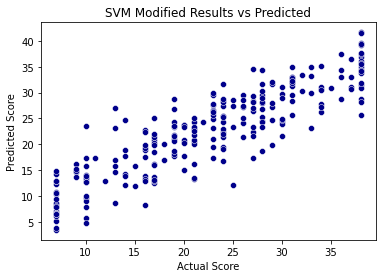

In [74]:
ax = sns.scatterplot(y_test_mod, svr_rbf_test_preds, color="darkblue")
ax.set(ylabel="Predicted Score", xlabel = "Actual Score",title = "SVM Modified Results vs Predicted")
plt.show()

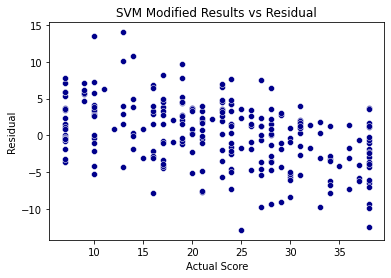

In [75]:
ax = sns.scatterplot(y_test_mod, svr_rbf_test_preds - y_test_mod, color = "darkblue")
ax.set(ylabel="Residual", xlabel = "Actual Score",title = "SVM Modified Results vs Residual")
plt.show()

As we can see in the plot of the residuals we are still running into the issue that we are underpredicting high scores and overpredicting low scores. In most cases this would be more of an issue but for this data it is somewhat expected. In order for a team to score less than 10 points normally means that they had some untimely turnovers or bad luck. The opposite is true for when a team scores over 35 points. The middle of the data looks evenly distriubted. We just need out model to be on the correct side of the vegas total so it is okay if we are a little off on projecting the extreams as long as our model does a good job of projecting an average game.

The best model for this data is either the ensembel model or the SVM model on the modified results. It is interesting to see that the SVM model actaully predicted much better on the test data than it did with the validation data. Going for I would probably choose the ensembel method since it did a good job with both the validation data and the test data. Not to mention it includes the SVM model as a part of it.

## Next Steps

Now that we have a good model it can be used to predict scores against the spread. A real measure of success of this model will be when the results are compared to the vegas spread and not just the actual output. A future project could include the spread or total as the target variable. This could also be turned into a classification task where the results are either over or under. One area where this model could be improved is by using some of the more advanced analytics like expected points added or position grades. By using mostly just counting stats we are missing out on the effectiveness and efficiency asspect of games. It would also be interesting to use offensive line/ deffensive line grades. A team having a large advantage on the line normally has a possitvie impact on the game that isn't neccesarily captured in the box score.

In [201]:
#Removed 1st downs as it had a high p-value showing that it was not predictive
#Renived Passing yards and rushing yards as it doesn't improve the linear model but unnecessarily increases the 
#simultaitons complexity
X = df.drop(['Tm', 'OppScore','Opp', 'Team'], axis=1)
X = X.drop(['RushY'], axis=1)
X = X.drop(['PassY'], axis=1)
X = X.drop(['1stD'], axis=1)
X = X.drop(['Opp1stD'], axis=1)
X = X.drop(['OppPassY'], axis=1)
X = X.drop(['OppRushY'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=RANDOM_STATE)
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                     Tm   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     1221.
Date:                Mon, 23 Jan 2023   Prob (F-statistic):               0.00
Time:                        20:15:09   Log-Likelihood:                -6789.7
No. Observations:                2302   AIC:                         1.360e+04
Df Residuals:                    2294   BIC:                         1.364e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0042      0.831      6.020      0.0

# Monte Carlo Simulation

For the monte carlo simulation we need to grab the average and standard deviation statistics for each team in 2022

In [114]:
allmeans = pd.read_csv('NFL_means_2022.csv',sep="\t",index_col=0 )
print("\tMean stats for all teams in 2022\n\n",allmeans.head())
allStds = pd.read_csv('NFL_Stds_2022.csv',sep="\t",index_col=0 )
print("\n\tStandard deviation stats for all teams in 2022\n\n",allStds.head())

	Mean stats for all teams in 2022

        Offense   Defense         Tm   OppScore   Sp. Tms        TO       1stD  \
atl   4.053125 -8.096875  20.937500  23.062500  1.871875  1.250000  19.250000   
buf  10.071333  0.557333  28.000000  17.533333  0.330667  1.600000  23.266667   
car   0.209375 -3.510625  21.062500  22.937500  2.195625  1.187500  16.687500   
chi  -0.086875 -9.536875  19.562500  27.125000  1.702500  1.437500  16.562500   
cin   8.720667 -1.518667  26.066667  20.400000 -1.164000  1.133333  22.800000   

          TotYd       PassY     RushY    Opp1stD    OppTotYd    OppPassY  \
atl  314.687500  155.687500  159.0000  21.187500  370.875000  237.875000   
buf  402.266667  259.466667  142.8000  19.533333  317.666667  213.266667   
car  312.687500  185.250000  127.4375  20.625000  353.062500  231.687500   
chi  310.875000  129.875000  181.0000  20.812500  369.250000  210.937500   
cin  367.400000  269.200000   98.2000  18.333333  332.333333  225.933333   

     OppRushY     Op

Now we need to pull out each statstic and save it by its team name so it is easier to access in our simulation

In [161]:
league_avg=allmeans.mean()

for x in TeamLst:
    globals()[f'{x}'] =[allmeans.loc[x],allStds.loc[x]]
print("Washington Averages")
print(was[0])

Washington Averages
Offense      -1.191875
Defense      -1.298750
Tm           18.437500
OppScore     21.062500
Sp. Tms      -0.253750
TO            1.375000
1stD         20.187500
TotYd       331.625000
PassY       207.125000
RushY       124.500000
Opp1stD      17.250000
OppTotYd    312.250000
OppPassY    195.875000
OppRushY    116.375000
OppTO         1.000000
Name: was, dtype: float64


In [243]:
# Full Point Total Simulation
from matplotlib import pyplot as plt

def bootstrap(x, confidence=.68, nSamples=100):
    # Make "nSamples" new datasets by re-sampling x with replacement
    # the size of the samples should be the same as x itself
    means = []
    for k in range(nSamples):
        sample = np.random.choice(x, size=len(x), replace=True)
        means.append(np.mean(sample))
    means.sort()
    leftTail = int(((1.0 - confidence)/2) * nSamples)
    rightTail = (nSamples - 1) - leftTail
    return round(np.mean(x),2)

class MonteCarlo:
    def SimulateOnce(self):
        raise NotImplementedError   
    # This function computes the value at risk amount for the results of a simulation
    # It can only be run after the main simulation is run, so in this funciton we
    # test for whether the results member exists and if not, print an error    
    def var(self, risk = .05):
        if hasattr(self, "results"):               # See if the results have been calculated 
            self.results.sort()                    # Sort them
            index = int(len(self.results)*risk)    # Count them and multiply by the risk factor  
            return(self.results[index])            # Return the value at that index
        else:
            print("RunSimulation must be executed before the method 'var'")
            return 0.0

    # This function runs the simulation.  Note that it stores the results of each of the
    # trials in an array that is a CLASS variable, not a local variable in this function
    # so, we can get this array from the MonteCarlo object after running if we wish.
    def RunSimulation(self, threshold=.001, simCount=10000):
        self.results = []       # Array to hold the results
        sum1 = 0.0              # Sum of the results
        sum2 = 0.0              # Sum of the results^2
        
        # Now, we set up the simulation loop
        self.convergence = False
        for k in range(simCount): 
            x = self.SimulateOnce()  
            # Run the simulation
            self.results.append(x)      # Add the result to the array
            sum1 += x                   # Add it to the sum
            sum2 += x*x                 # Add the square to the sum of squares
            
            # Go to at least a 100 cycles before testing for convergence.             
            if k > 100:
                mu = float(sum1)/k                  # Compute the mean
                var = (float(sum2)/(k-1)) - mu*mu   # An alternate calculation of the variance
                dmu = np.sqrt(var / k)              # Standard error of the mean
                                                    
                # If the estimate of the error in mu is within "threshold" percent
                # then set convergence to true.  We could also break out early at this 
                # point if we wanted to 
                if dmu < abs(mu) * threshold:
                    self.convergence = True  
        # Bootstrap the results and return not only the mean, but the confidence interval
        # as well.  [mean - se, mean, mean + se]
        plt.hist(self.results, 20,edgecolor='black')
        font1 = {'family':'serif','color':'darkred','size':15}
        plt.xlabel("Points Scored",fontdict = font1)
        plt.ylabel("Simulations",fontdict = font1)
        plt.title("Simulation Results",fontdict = font1)
        plt.show()
        return bootstrap(self.results)
    
class nflScores(MonteCarlo):
    def __init__(self,team,opponent):
        self.team     = team
        self.opponent = opponent
        
        self.off_epa_avg = team[0][0]
        self.def_epa_avg = team[0][1]
        self.st_ep_avg   = team[0][4]
        self.to_Avg      = team[0][5]
        self.totalYards_avg = team[0][7]
        
        self.off_epa_sd = team[1][0]
        self.def_epa_sd = team[1][1]
        self.st_epa_sd  = team[1][4]
        self.to_sd      = team[1][5]
        self.totalYards_sd   = team[1][7]
        
        self.opp_to_avg      = opponent[0][5]
        self.opp_off_epa_avg = opponent[0][0]
        self.opp_def_epa_avg = opponent[0][1]
        self.opp_totalYards_avg   = opponent[0][7]
        
        self.opp_off_epa_sd  = opponent[1][0]
        self.opp_def_epa_sd  = opponent [1][1]
        self.opp_totalYards_sd   = opponent[1][7]

    def SimulateOnce(self):
        #Covariance between Offensive EPA and Total Yards
        offensiveCov=np.array([[146.179,759.455],[759.455188,7246.630954]])
        offensiveMean= (self.off_epa_avg,self.totalYards_avg) 
        #Accounts for the covariance between offensive epa and total yards
        offEP,totYd =np.random.multivariate_normal(offensiveMean,offensiveCov).T 
        
        opp_offensiveMean= (self.opp_off_epa_avg,self.opp_totalYards_avg)
        opp_off_EP,opp_totYd =np.random.multivariate_normal(offensiveMean,offensiveCov).T 

        defEP=np.random.normal(self.def_epa_avg,self.def_epa_sd)
        opp_Def_EP=np.random.normal(self.opp_def_epa_avg, self.opp_def_epa_sd)
        offEP=(offEP-opp_Def_EP)/2
        defEP=(defEP-opp_off_EP)/2
        stEP=np.random.normal(self.st_ep_avg,self.st_epa_sd)
        
        to=round(np.random.exponential(self.to_Avg))
        oppTo=round(np.random.exponential( self.opp_to_avg))
 
        points= 5.0 + (0.69*offEP) + (0.27*defEP) + (0.43*stEP) + (1.06*to) + (0.0174*totYd) + (1.27*oppTo) + (opp_totYd*0.0208)
        return max(points,0)       #This forces the projection to be non-negative
    
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [218]:
def gameSim(team,opponent):
    sim=nflScores(team,opponent)
    teamScore=sim.RunSimulation()
    sim=nflScores(opponent,team)
    opponentScore=sim.RunSimulation()
    total=round((teamScore+opponentScore),1)
    print(str(total) +" is the projected point total")
    if teamScore > opponentScore:
        dif=round((teamScore-opponentScore),1)
        print((namestr(team, globals())[0])+" is projected to win by "+ str(dif)+" points")
    else:
        dif=round((opponentScore-teamScore),1)
        print((namestr(opponent, globals())[0])+" is projected to win by "+ str(dif)+" points")

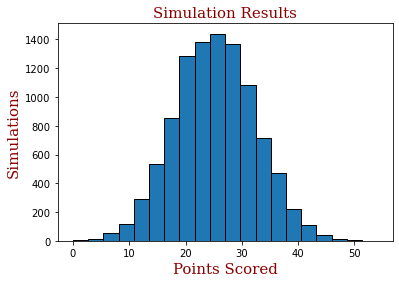

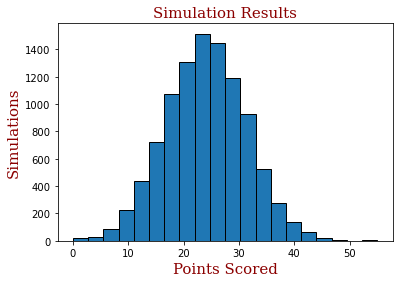

49.2 is the projected point total
kan is projected to win by 1.2 points


In [258]:
#Game Simulation
gameSim(kan,cin)